In [93]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import math
import pickle
from sklearn.preprocessing import MinMaxScaler
import pickle

In [94]:
def checkSpecial(url):
    """Returns number of special characters in string"""
    regex = re.compile('[@_!#$%^&*()<>?|}{~]')
    return len([c for c in url if regex.search(c)])

def getNums(url):
    """Returns number of digits in string"""
    return len([c for c in url if c.isdigit()])

def entropy(url):
    """Returns entropy of string"""
    s = url.strip()
    prob = [float(s.count(c)) / len(s) for c in dict.fromkeys(list(s))]
    ent = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
    return ent

def numSubDomains(url):
    """Returns number of subdomains in the given URL"""
    subdomains = url.split('http')[-1].split('//')[-1].split('/')
    return len(subdomains)-1

def feature_transform(df):
    """Featurizes the URL string into the data frame"""
    df.insert(2, 'len_url', [len(url) for url in df['URL']])
    df.insert(2, 'numerical', [getNums(url) for url in df['URL']])
    df.insert(2, 'special', [checkSpecial(url) for url in df['URL']])
    df.insert(2, 'hasPercent', [1 if ('%' in url) else 0 for url in df['URL']])
    df.insert(2, 'entropy', [entropy(url) for url in df['URL']])
    df.insert(2, 'numSD', [numSubDomains(url) for url in df['URL']])
    del df['URL']

In [95]:
df = pd.read_csv('Phishing_Dataset.csv')


In [96]:
df.head()

,create_age(months),expiry_age(months),update_age(days),URL,Label
0,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1
1,212,16,663,http://www.coffeespecialties.com/...,0
2,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1
3,198,6,186,http://atomicsoda.com/manutd...,0
4,240,24,1684,http://bostoncoffeecake.com/...,0


In [97]:
feature_transform(df)

In [98]:
new_df=df.drop(["create_age(months)","expiry_age(months)","update_age(days)","Label"],axis="columns")

In [99]:
new_df=new_df[["len_url","numerical","special","hasPercent","entropy","numSD"]]

In [100]:
new_df

,len_url,numerical,special,hasPercent,entropy,numSD
0,70,21,0,0,-4.612783,1
1,36,0,0,0,-3.819114,1
2,73,21,0,0,-4.370385,5
3,31,0,0,0,-3.695501,1
4,31,0,0,0,-3.760017,1
...,...,...,...,...,...,...
4794,73,19,1,0,-4.742582,4
4795,26,0,0,0,-3.507380,1
4796,73,7,0,0,-4.579566,4
4797,73,4,0,0,-4.441882,6


In [101]:

y = df.pop('Label')

x_train, x_test, y_train, y_test = train_test_split(new_df, y, test_size=0.2, random_state=0)

mm=MinMaxScaler().fit(x_train) 
def norm(x):
    return mm.transform(x)
normed_train = norm(x_train)
normed_test = norm(x_test)

In [102]:
x_train.shape

(3839, 6)

In [103]:
x_train.iloc[34].values


array([64.       , 17.       ,  0.       ,  0.       , -4.4475274,
        4.       ])

In [104]:
normed_train

array([[0.08888889, 0.        , 0.        , 0.        , 0.85401493,
        0.11111111],
       [0.22222222, 0.        , 0.        , 0.        , 0.6826271 ,
        0.11111111],
       [0.24444444, 0.        , 0.        , 0.        , 0.59180928,
        0.11111111],
       ...,
       [0.15555556, 0.        , 0.        , 0.        , 0.62063005,
        0.11111111],
       [0.46666667, 0.54054054, 0.        , 0.        , 0.31694197,
        0.22222222],
       [0.62222222, 0.05405405, 0.0625    , 0.        , 0.24041182,
        0.44444444]])

In [105]:
def build_model():
    tf.random.set_seed(42)  
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=[len(x_train.columns)]),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(25, activation='relu', kernel_initializer='he_normal'),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [106]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               700       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 7,051
Trainable params: 7,051
Non-trainable params: 0
____________________________________________________

In [107]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=10)

history = model.fit(normed_train, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[callback])

Epoch 1/150
96/96 [==============================] - 1s 3ms/step - loss: 0.5511 - accuracy: 0.7038 - val_loss: 0.3481 - val_accuracy: 0.8542
Epoch 2/150
96/96 [==============================] - 0s 2ms/step - loss: 0.4045 - accuracy: 0.8360 - val_loss: 0.3499 - val_accuracy: 0.8698
Epoch 3/150
96/96 [==============================] - 0s 3ms/step - loss: 0.4011 - accuracy: 0.8423 - val_loss: 0.3296 - val_accuracy: 0.8620
Epoch 4/150
96/96 [==============================] - 0s 2ms/step - loss: 0.3641 - accuracy: 0.8559 - val_loss: 0.3251 - val_accuracy: 0.8594
Epoch 5/150
96/96 [==============================] - 0s 2ms/step - loss: 0.3585 - accuracy: 0.8627 - val_loss: 0.3216 - val_accuracy: 0.8633
Epoch 6/150
96/96 [==============================] - 0s 2ms/step - loss: 0.3656 - accuracy: 0.8559 - val_loss: 0.3298 - val_accuracy: 0.8672
Epoch 7/150
96/96 [==============================] - 0s 2ms/step - loss: 0.3688 - accuracy: 0.8540 - val_loss: 0.3186 - val_accuracy: 0.8659
Epoch 8/150
9

In [108]:
score = model.evaluate(normed_test, y_test)

# test_predictions = model.predict(normed_test).flatten()
# predictions = [int(round(value)) for value in test_predictions]
# print(predictions)

30/30 [==============================] - 0s 689us/step - loss: 0.3145 - accuracy: 0.8760


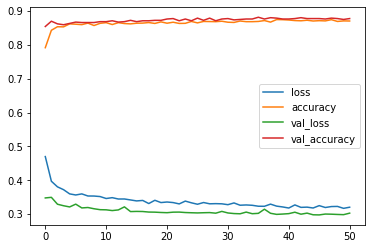

In [109]:
pd.DataFrame(history.history).plot()

In [110]:
model.save("model1.h5")

In [111]:
pickle.dump(mm,open("scale.pkl","wb"))

0 is safe<br>1 is phishing